In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

%pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.metrics.cluster import rand_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree

import xgboost as xgb

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import eli5
from eli5.sklearn import PermutationImportance
import shap 

import shap
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/data/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Note: you may need to restart the kernel to use updated packages.


In [6]:
client_credentials_manager = SpotifyClientCredentials(client_id="id", client_secret="secret")
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [7]:
def get_track_attribute(query, feature = 'valence'):
    try:
        results = sp.search(q=query, limit=1, type='track')
        track = results['tracks']['items'][0]
        features = sp.audio_features(track['id'])
        return features[0][feature]
    except:
        return None

def get_artist_attribute(artist_name, feature = 'valence'):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist')
        artist_id = results['artists']['items'][0]['id']
        tracks = sp.artist_top_tracks(artist_id)
        audio_features = []
        for track in tracks['tracks'][:5]:
            audio_features.append(sp.audio_features(track['id'])[0])
        attribute = sum([af[feature] for af in audio_features]) / len(audio_features)
        return attribute
    except Exception as error:
#         print(error)
        return None

In [8]:
def add_artist_attributes(df, col, num):
    
    # Create empty lists to store attribute values
    track_id_list = []
#     popularity_list = []
    duration_ms_list = []
#     explicit_list = []
    danceability_list = []
    energy_list = []
    key_list = []
    loudness_list = []
    mode_list = []
    speechiness_list = []
    acousticness_list = []
    instrumentalness_list = []
    liveness_list = []
    valence_list = []
    tempo_list = []

    # Loop through each song in the dataframe
    for artist_name in df[col]:
        try:
#             popularity_list.append(get_artist_attribute(artist_name,'popularity'])
            duration_ms_list.append(get_artist_attribute(artist_name, 'duration_ms'))
#             explicit_list.append(get_artist_attribute(artist_name,'explicit']))
            danceability_list.append(get_artist_attribute(artist_name,'danceability'))
            energy_list.append(get_artist_attribute(artist_name,'energy'))
            key_list.append(get_artist_attribute(artist_name,'key'))
            loudness_list.append(get_artist_attribute(artist_name,'loudness'))
            mode_list.append(get_artist_attribute(artist_name,'mode'))
            speechiness_list.append(get_artist_attribute(artist_name,'speechiness'))
            acousticness_list.append(get_artist_attribute(artist_name,'acousticness'))
            instrumentalness_list.append(get_artist_attribute(artist_name,'instrumentalness'))
            liveness_list.append(get_artist_attribute(artist_name,'liveness'))
            valence_list.append(get_artist_attribute(artist_name,'valence'))
            tempo_list.append(get_artist_attribute(artist_name,'tempo'))
        except Exception as error:
            print(error)
            # If an error occurs, add None values to the attribute lists
            track_id_list.append(None)
#             popularity_list.append(None)
            duration_ms_list.append(None)
#             explicit_list.append(None)
            danceability_list.append(None)
            energy_list.append(None)
            key_list.append(None)
            loudness_list.append(None)
            mode_list.append(None)
            speechiness_list.append(None)
            acousticness_list.append(None)
            instrumentalness_list.append(None)
            liveness_list.append(None)
            valence_list.append(None)
            tempo_list.append(None)

    # Add new columns to the dataframe with the attribute lists
#     df['Popularity'+num] = popularity_list
    df['Artist_Duration (ms)'+num] = duration_ms_list
    df['Artist_Danceability'+num] = danceability_list
    df['Artist_Energy'+num] = energy_list
#     dfArtist_['Key'+num] = key_list
    df['Artist_Loudness'+num] = loudness_list
    df['Artist_Mode'+num] = mode_list
    df['Artist_Speechiness'+num] = speechiness_list
    df['Artist_Acousticness'+num] = acousticness_list
    df['Artist_Instrumentalness'+num] = instrumentalness_list
    df['Artist_Liveness'+num] = liveness_list
    df['Artist_Valence'+num] = valence_list
    df['Artist_Tempo'+num] = tempo_list
    print('done')
    return df

In [9]:
def add_song_attributes(df, col, num):
    
    # Create empty lists to store attribute values
    track_id_list = []
#     popularity_list = []
    duration_ms_list = []
#     explicit_list = []
    danceability_list = []
    energy_list = []
    key_list = []
    loudness_list = []
    mode_list = []
    speechiness_list = []
    acousticness_list = []
    instrumentalness_list = []
    liveness_list = []
    valence_list = []
    tempo_list = []

    # Loop through each song in the dataframe
    for song_name in df[col]:
        try:
            # Get the track ID from Spotify API using the song name
            results = sp.search(q=song_name, limit=1)
            track_id = results['tracks']['items'][0]['id']
            track_id_list.append(track_id)
            
            # Get the track attributes from Spotify API using the track ID
            track_features = sp.audio_features(tracks=[track_id])[0]
#             popularity_list.append(track_features['popularity'])
            duration_ms_list.append(track_features['duration_ms'])
#             explicit_list.append(track_features['explicit'])
            danceability_list.append(track_features['danceability'])
            energy_list.append(track_features['energy'])
            key_list.append(track_features['key'])
            loudness_list.append(track_features['loudness'])
            mode_list.append(track_features['mode'])
            speechiness_list.append(track_features['speechiness'])
            acousticness_list.append(track_features['acousticness'])
            instrumentalness_list.append(track_features['instrumentalness'])
            liveness_list.append(track_features['liveness'])
            valence_list.append(track_features['valence'])
            tempo_list.append(track_features['tempo'])
        except Exception as error:
#             print(error)
            # If an error occurs, add None values to the attribute lists
            track_id_list.append(None)
#             popularity_list.append(None)
            duration_ms_list.append(None)
#             explicit_list.append(None)
            danceability_list.append(None)
            energy_list.append(None)
            key_list.append(None)
            loudness_list.append(None)
            mode_list.append(None)
            speechiness_list.append(None)
            acousticness_list.append(None)
            instrumentalness_list.append(None)
            liveness_list.append(None)
            valence_list.append(None)
            tempo_list.append(None)

    # Add new columns to the dataframe with the attribute lists
#     df['Popularity'+num] = popularity_list
    df['Duration (ms)'+num] = duration_ms_list
    df['Danceability'+num] = danceability_list
    df['Energy'+num] = energy_list
#     df['Key'+num] = key_list
    df['Loudness'+num] = loudness_list
    df['Mode'+num] = mode_list
    df['Speechiness'+num] = speechiness_list
    df['Acousticness'+num] = acousticness_list
    df['Instrumentalness'+num] = instrumentalness_list
    df['Liveness'+num] = liveness_list
    df['Valence'+num] = valence_list
    df['Tempo'+num] = tempo_list
    
    return df

In [10]:
get_track_attribute('Alison')

0.278

In [14]:
df = pd.read_csv("SIN Project (Responses) - Form Responses 1.csv")

In [15]:
df['1st_track_features'] = df['Top tracks of your Spotify wrapped (1st)'].apply(get_track_attribute)
df['2nd_track_features'] = df['Top tracks of your Spotify wrapped (2nd)'].apply(get_track_attribute)
df['3rd_track_features'] = df['Top tracks of your Spotify wrapped (3rd)'].apply(get_track_attribute)
df['4th_track_features'] = df['Top tracks of your Spotify wrapped (4th)'].apply(get_track_attribute)
df['5th_track_features'] = df['Top tracks of your Spotify wrapped (5th)'].apply(get_track_attribute)

In [16]:
df = add_song_attributes(df, 'Top tracks of your Spotify wrapped (1st)', '1')
df = add_song_attributes(df, 'Top tracks of your Spotify wrapped (2nd)', '2')
df = add_song_attributes(df, 'Top tracks of your Spotify wrapped (3rd)', '3')
df = add_song_attributes(df, 'Top tracks of your Spotify wrapped (4th)', '4')
df = add_song_attributes(df, 'Top tracks of your Spotify wrapped (5th)', '5')

In [ ]:
# df['1st_artist_features'] = df['Top artists of your Spotify wrapped (1st) '].apply(get_artist_attribute)
# df['2nd_artist_features'] = df['Top artists of your Spotify wrapped (2nd) '].apply(get_artist_attribute)
# df['3rd_artist_features'] = df['Top artists of your Spotify wrapped (3rd) '].apply(get_artist_attribute)
# df['4th_artist_features'] = df['Top artists of your Spotify wrapped (4th) '].apply(get_artist_attribute)
# df['5th_artist_features'] = df['Top artists of your Spotify wrapped (5th) '].apply(get_artist_attribute)

In [ ]:
# df = add_artist_attributes(df, 'Top artists of your Spotify wrapped (1st) ', '1')
# df = add_artist_attributes(df, 'Top artists of your Spotify wrapped (2nd) ', '2')
# df = add_artist_attributes(df, 'Top artists of your Spotify wrapped (3rd) ', '3')
# df = add_artist_attributes(df, 'Top artists of your Spotify wrapped (4th) ', '4')
# df = add_artist_attributes(df, 'Top artists of your Spotify wrapped (5th) ', '5')

In [17]:
df["O"] = 8 + df.iloc[:,20] - df.iloc[:,25] + df.iloc[:,30] - df.iloc[:,35] + df.iloc[:,40] - df.iloc[:,45] + df.iloc[:,50] + df.iloc[:,55] + df.iloc[:,60] + df.iloc[:,65]  
df["C"] = 14 + df.iloc[:,18] - df.iloc[:,23] + df.iloc[:,28] - df.iloc[:,33] + df.iloc[:,38] - df.iloc[:,43] + df.iloc[:,48] - df.iloc[:,53] + df.iloc[:,58] + df.iloc[:,63]
df["E"] = 20 + df.iloc[:,16] - df.iloc[:,21] + df.iloc[:,26] - df.iloc[:,31] + df.iloc[:,36] - df.iloc[:,41] + df.iloc[:,46] - df.iloc[:,51] + df.iloc[:,56] - df.iloc[:,61]
df["A"] = 14 - df.iloc[:,17] + df.iloc[:,22] - df.iloc[:,27] + df.iloc[:,32] - df.iloc[:,37] + df.iloc[:,42] - df.iloc[:,47] + df.iloc[:,52] + df.iloc[:,57] + df.iloc[:,62] 
df["N"] = 38 - df.iloc[:,19] + df.iloc[:,24] - df.iloc[:,29] + df.iloc[:,34] - df.iloc[:,39] - df.iloc[:,44] - df.iloc[:,49] - df.iloc[:,54] - df.iloc[:,59] - df.iloc[:,64] 

In [20]:
df.columns

Index(['Timestamp', 'Top tracks of your Spotify wrapped (1st)',
       'Top tracks of your Spotify wrapped (2nd)',
       'Top tracks of your Spotify wrapped (3rd)',
       'Top tracks of your Spotify wrapped (4th)',
       'Top tracks of your Spotify wrapped (5th)',
       'Top artists of your Spotify wrapped (1st) ',
       'Top artists of your Spotify wrapped (2nd) ',
       'Top artists of your Spotify wrapped (3rd) ',
       'Top artists of your Spotify wrapped (4th) ',
       ...
       'Acousticness5', 'Instrumentalness5', 'Liveness5', 'Valence5', 'Tempo5',
       'O', 'C', 'E', 'A', 'N'],
      dtype='object', length=131)

In [21]:
df.fillna(df.mean(), inplace=True)

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [23]:
df[["O", "C", "E", "A", "N"]].describe()

,O,C,E,A,N
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,26.836735,23.959184,21.040816,25.918367,20.163265
std,5.145171,5.894769,6.288081,4.881243,7.340944
min,12.000000,9.000000,7.000000,16.000000,4.000000
25%,23.000000,20.000000,17.000000,23.000000,17.000000
50%,28.000000,25.000000,21.000000,26.000000,20.000000
75%,30.000000,28.000000,26.000000,29.000000,26.000000
max,36.000000,35.000000,36.000000,37.000000,34.000000


In [24]:
cols = df.columns[66:].to_list()
corr = df[cols].corr().to_numpy()
fig = px.imshow(corr, aspect="auto", x = cols, y = cols,
                color_continuous_scale='RdBu', color_continuous_midpoint=0)
fig.update_xaxes(side="top")
fig.show()

In [25]:
df = df.applymap(lambda x: x.upper().strip() if isinstance(x, str) else x)
df_artists = df['Top artists of your Spotify wrapped (1st) '].to_list()+df['Top artists of your Spotify wrapped (2nd) '].to_list()+df['Top artists of your Spotify wrapped (3rd) '].to_list()+df['Top artists of your Spotify wrapped (4th) '].to_list()+df['Top artists of your Spotify wrapped (5th) '].to_list()

In [26]:
df_artists = pd.DataFrame(df_artists)
artists_count = df_artists[0].value_counts()

<Axes: xlabel='0'>

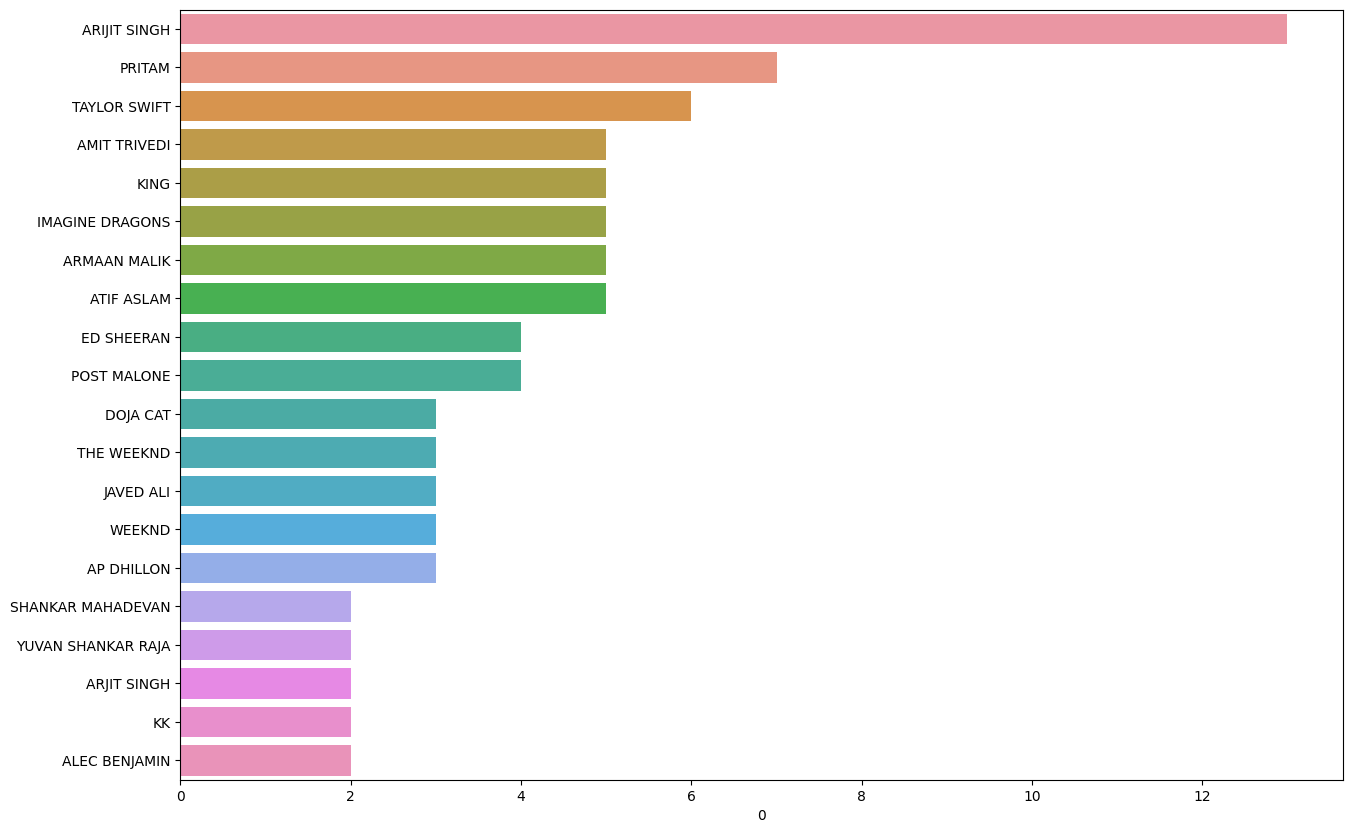

In [27]:
sns.barplot(x = artists_count[:20], y = artists_count.index[:20])

In [28]:
df_train1 = df[["O", "C", "E", "A", "N"]]
# df_train2 = df.iloc[:,121:]
df_train3 = df.iloc[:,66:121]
df_train4 = df.iloc[:, 16:66]

In [29]:
df_train1 = (df_train1-df_train1.min())/(df_train1.max()-df_train1.min())
df_train3 = (df_train3-df_train3.min())/(df_train3.max()-df_train3.min())
df_train4 = (df_train4-df_train4.min())/(df_train4.max()-df_train4.min())

In [30]:
kmeansQ = KMeans(n_clusters=5)
k_fit = kmeansQ.fit(df_train4)
predictions = k_fit.labels_
df['Q Clusters'] = predictions

C:\Users\sidha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [31]:
kmeansOcean = KMeans(n_clusters=5)
k_fit = kmeansOcean.fit(df_train1)
predictions = k_fit.labels_
df['OCEAN Clusters'] = predictions

C:\Users\sidha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [32]:
kmeansTracks = KMeans(n_clusters=5)
k_fit = kmeansTracks.fit(df_train3)
predictions = k_fit.labels_
df['Tracks Clusters'] = predictions

C:\Users\sidha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
# kmeansArtist = KMeans(n_clusters=5)
# k_fit = kmeansArtist.fit(df_train2)
# predictions = k_fit.labels_
# df['Artist Clusters'] = predictions

Text(0.5, 1.0, 'OCEAN Personality Clusters after PCA')

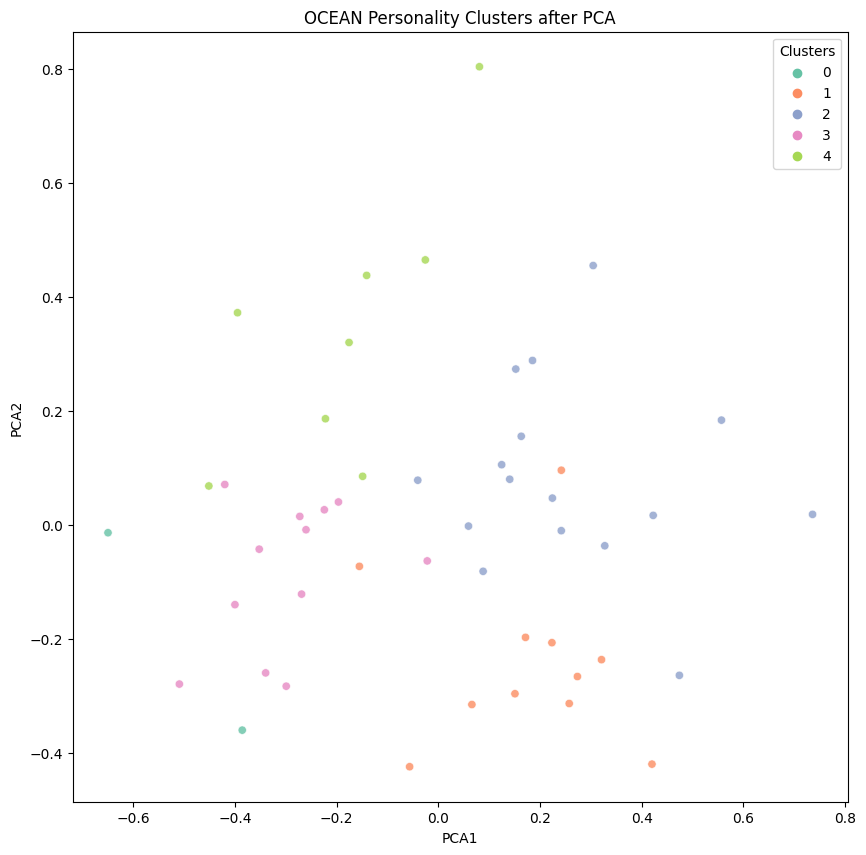

In [33]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(df_train1)

df_pca1 = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca1['Clusters'] = df['OCEAN Clusters']

plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca1, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=0.8)
plt.title('OCEAN Personality Clusters after PCA')

In [ ]:
# pca = PCA(n_components=2)
# pca_fit = pca.fit_transform(df_train2)

# df_pca2 = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
# df_pca2['Clusters'] = df['Artist Clusters']

# plt.figure(figsize=(10,10))
# sns.scatterplot(data=df_pca2, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=0.8)
# plt.title('Artist Personality Clusters after PCA')

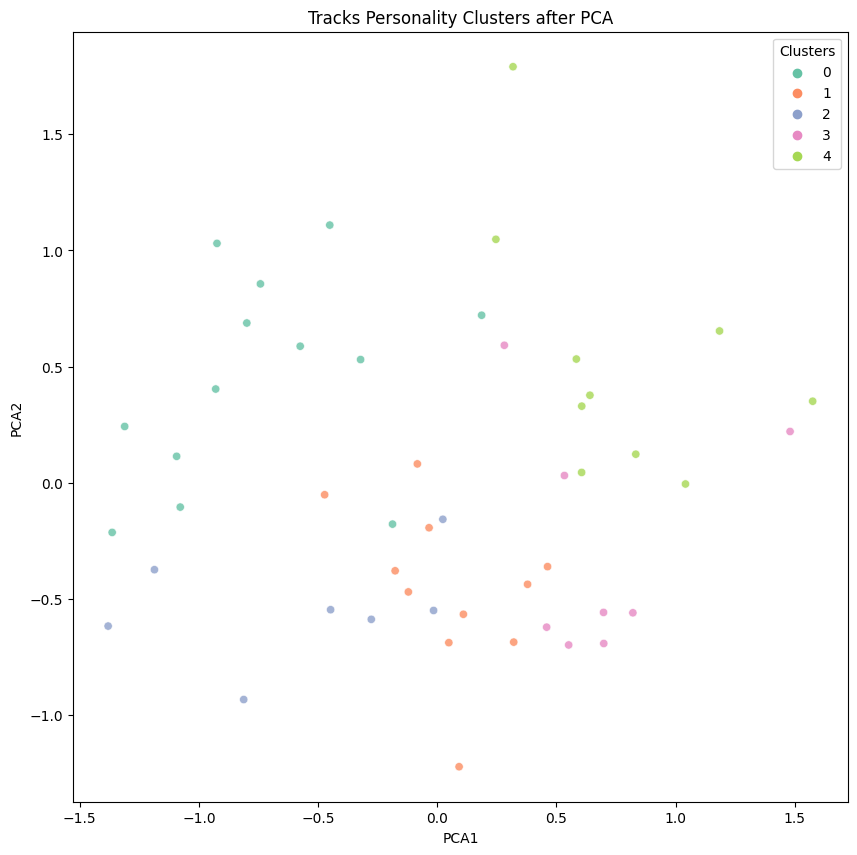

In [34]:
pca2 = PCA(n_components=2)
pca_fit = pca2.fit_transform(df_train3)

df_pca3 = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca3['Clusters'] = df['Tracks Clusters']

plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca3, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=0.8)
plt.title('Tracks Personality Clusters after PCA');


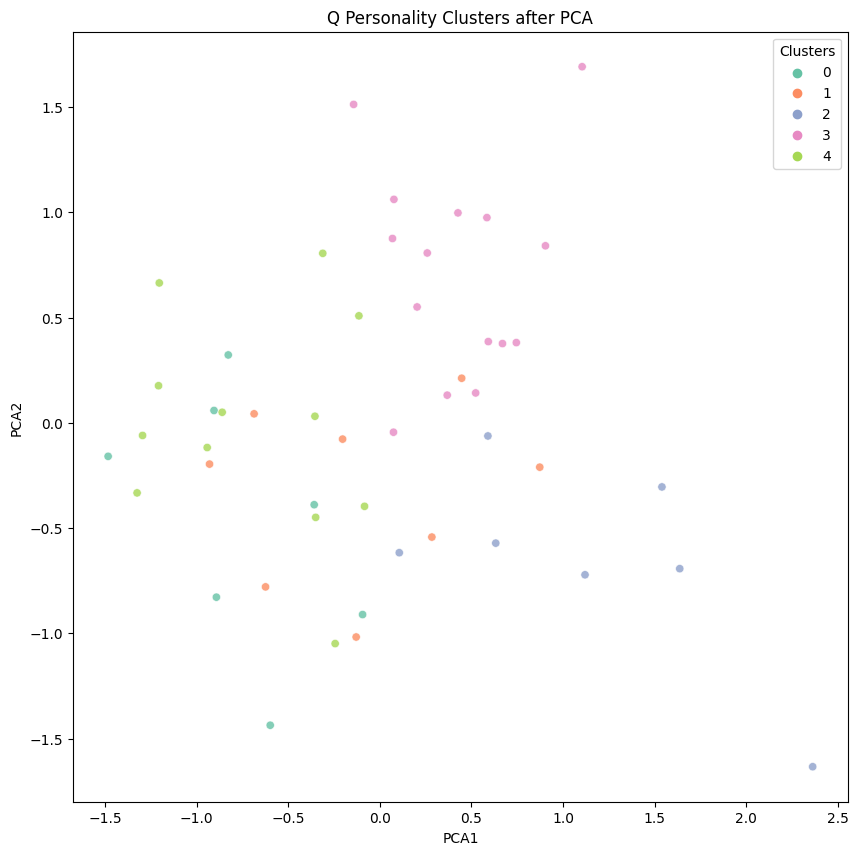

In [35]:
pca2 = PCA(n_components=2)
pca_fit = pca2.fit_transform(df_train4)

df_pca4 = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca4['Clusters'] = df['Q Clusters']

plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca4, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=0.8)
plt.title('Q Personality Clusters after PCA');


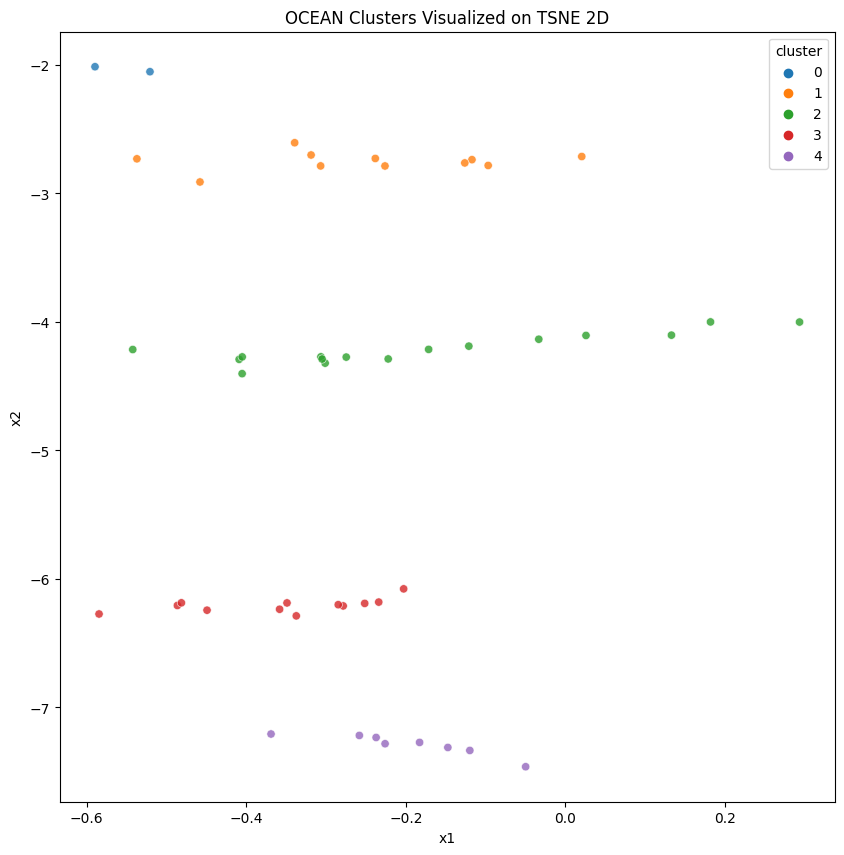

In [36]:
Xtsne = TSNE(n_components=2).fit_transform(df_pca1)
dftsne = pd.DataFrame(data=Xtsne , columns = ['x1','x2'])
dftsne['cluster'] = df['OCEAN Clusters']
plt.figure(figsize=(10,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full", palette='tab10', alpha=0.8)
plt.title('OCEAN Clusters Visualized on TSNE 2D');

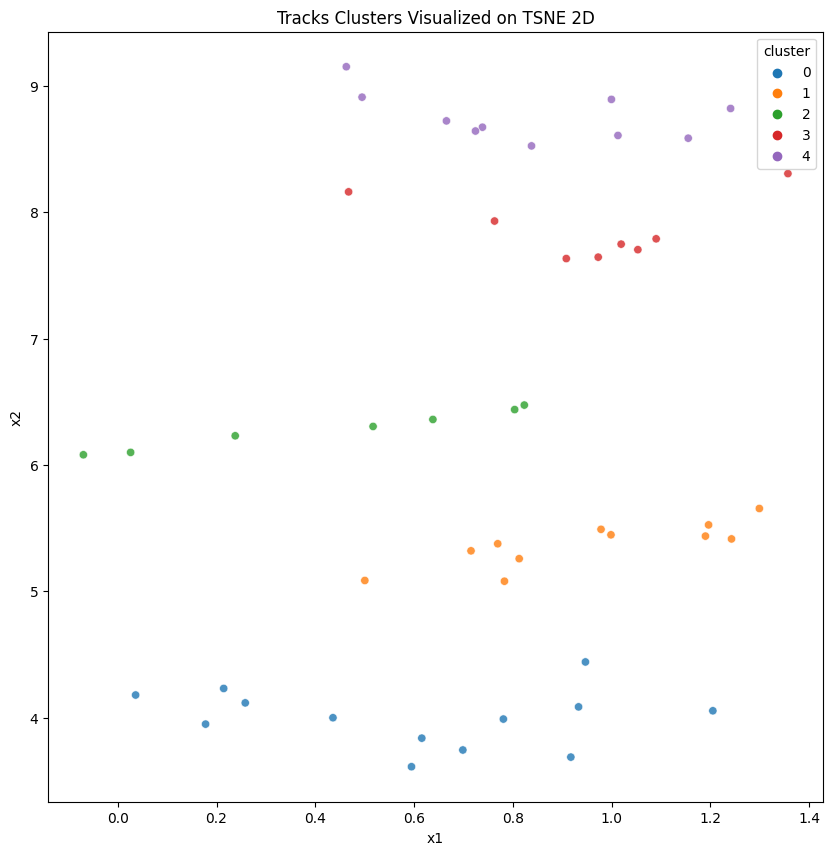

In [37]:
Xtsne = TSNE(n_components=2).fit_transform(df_pca3)
dftsne = pd.DataFrame(data=Xtsne , columns = ['x1','x2'])
dftsne['cluster'] = df['Tracks Clusters']
plt.figure(figsize=(10,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full", palette='tab10', alpha=0.8)
plt.title('Tracks Clusters Visualized on TSNE 2D');

In [ ]:
# Xtsne = TSNE(n_components=2).fit_transform(df_pca2)
# dftsne = pd.DataFrame(data=Xtsne , columns = ['x1','x2'])
# dftsne['cluster'] = df['Artist Clusters']
# plt.figure(figsize=(10,10))
# sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full", palette='tab10', alpha=0.8)
# plt.title('Artist Clusters Visualized on TSNE 2D');

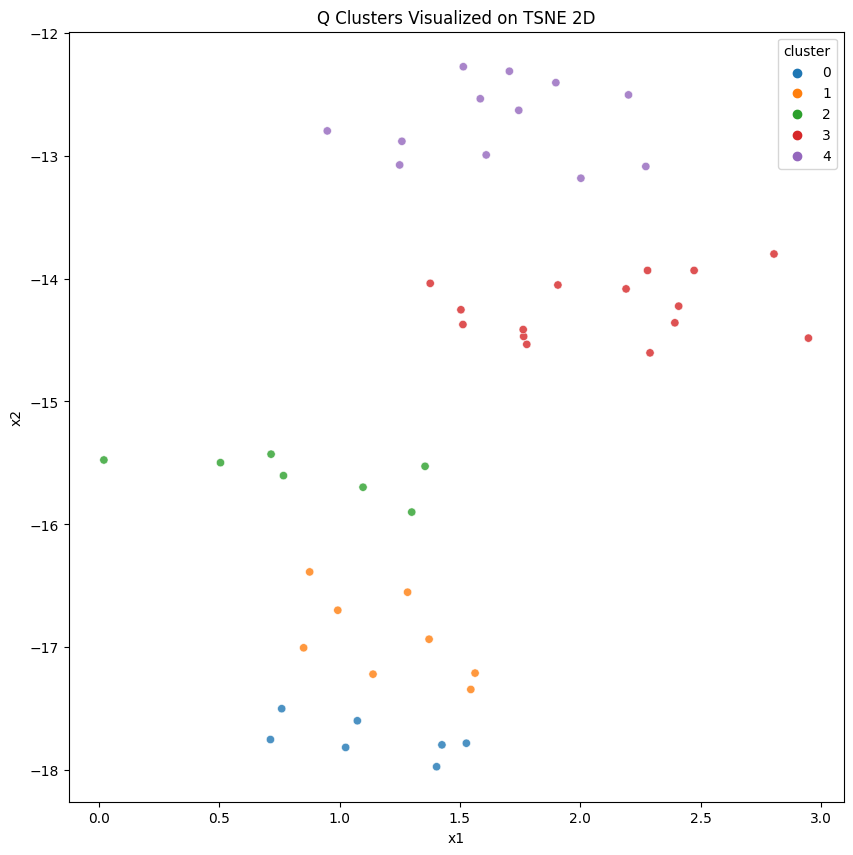

In [38]:
Xtsne = TSNE(n_components=2).fit_transform(df_pca4)
dftsne = pd.DataFrame(data=Xtsne , columns = ['x1','x2'])
dftsne['cluster'] = df['Q Clusters']
plt.figure(figsize=(10,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full", palette='tab10', alpha=0.8)
plt.title('Q Clusters Visualized on TSNE 2D');

In [39]:
print(rand_score(df['Tracks Clusters'], df['OCEAN Clusters']),
#       rand_score(df['Artist Clusters'], df['OCEAN Clusters']),
#       rand_score(df['Tracks Clusters'], df['Artist Clusters']),
      rand_score(df['Q Clusters'], df['OCEAN Clusters']),
#       rand_score(df['Artist Clusters'], df['Q Clusters']),
      rand_score(df['Tracks Clusters'], df['Q Clusters']))

0.6675170068027211 0.7100340136054422 0.673469387755102


In [42]:
xgb_clO = xgb.XGBClassifier(n_estimators = 1000, verbosity = 1,max_depth = 5, 
                           gamma = 0.2, subsample = 0.2, learning_rate = 0.3)
xgb_clO.fit(df_train1, df['OCEAN Clusters'])
xgb_clO.score(df_train1, df['OCEAN Clusters'])  

0.9591836734693877

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

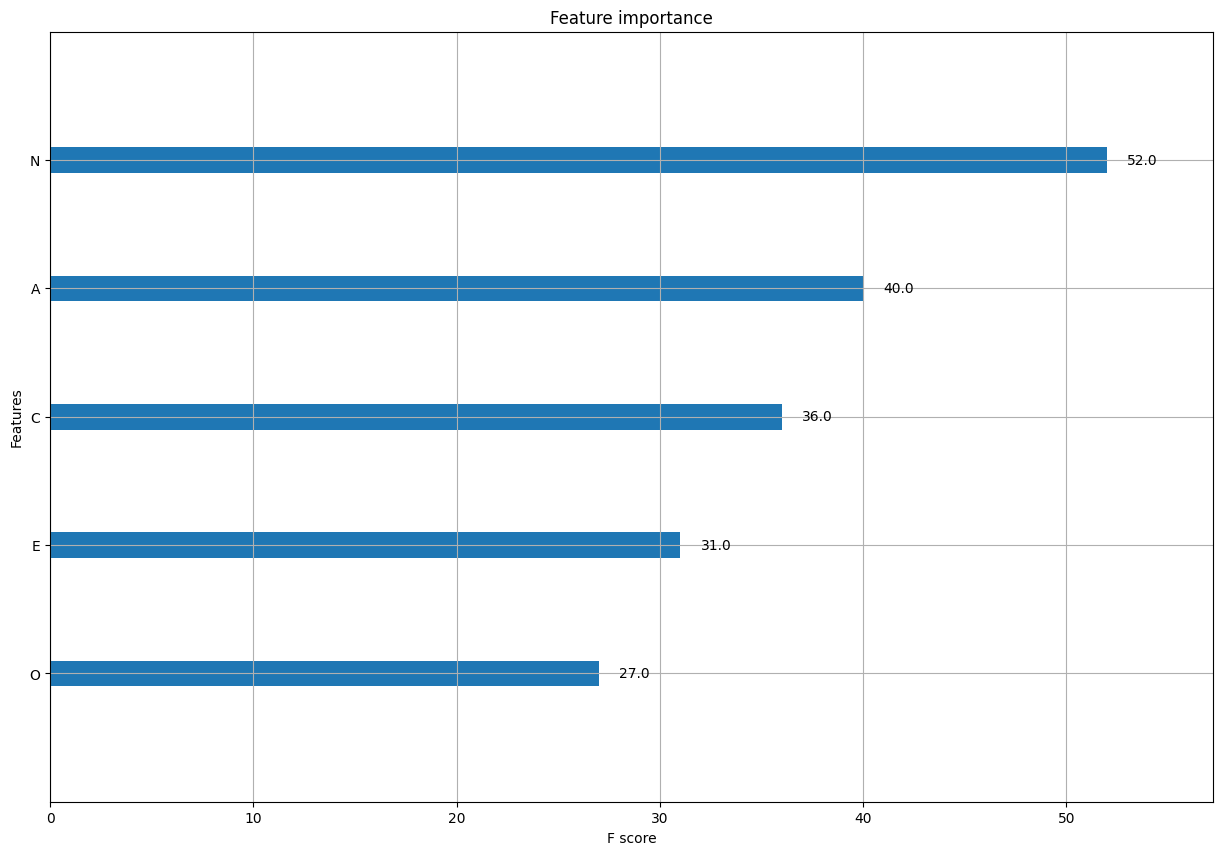

In [43]:
xgb.plot_importance(xgb_clO)

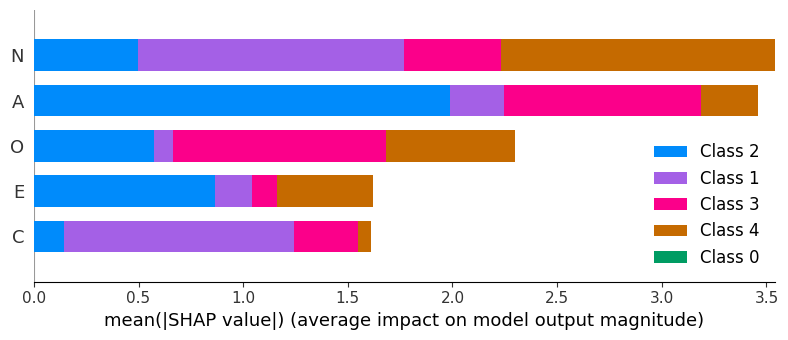

In [44]:
explainer = shap.TreeExplainer(xgb_clO)
shap_values = explainer.shap_values(df_train1)
shap.summary_plot(shap_values, df_train1)

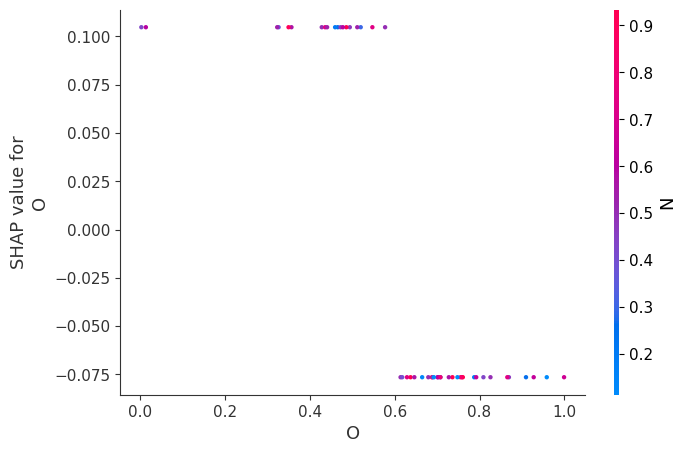

In [45]:
shap.dependence_plot('O', shap_values[1], df_train1, interaction_index="N",  x_jitter=1, dot_size=10)

In [46]:
xgb_clT = xgb.XGBClassifier(n_estimators = 1000, verbosity = 1,max_depth = 5, 
                           gamma = 0.2, subsample = 0.2, learning_rate = 0.3)
xgb_clT.fit(df_train3, df['Tracks Clusters'])
xgb_clT.score(df_train3, df['Tracks Clusters'])  

1.0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

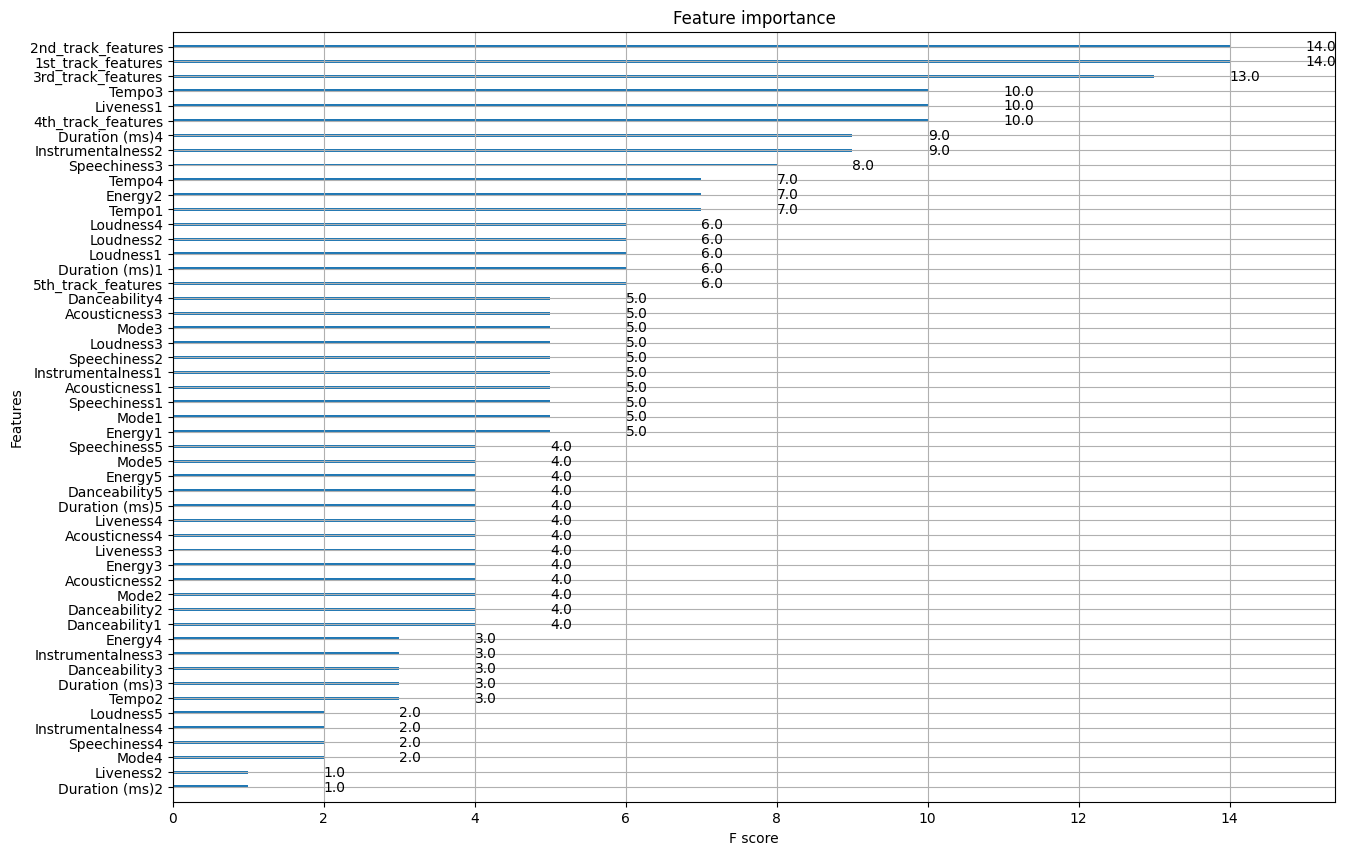

In [47]:
xgb.plot_importance(xgb_clT)

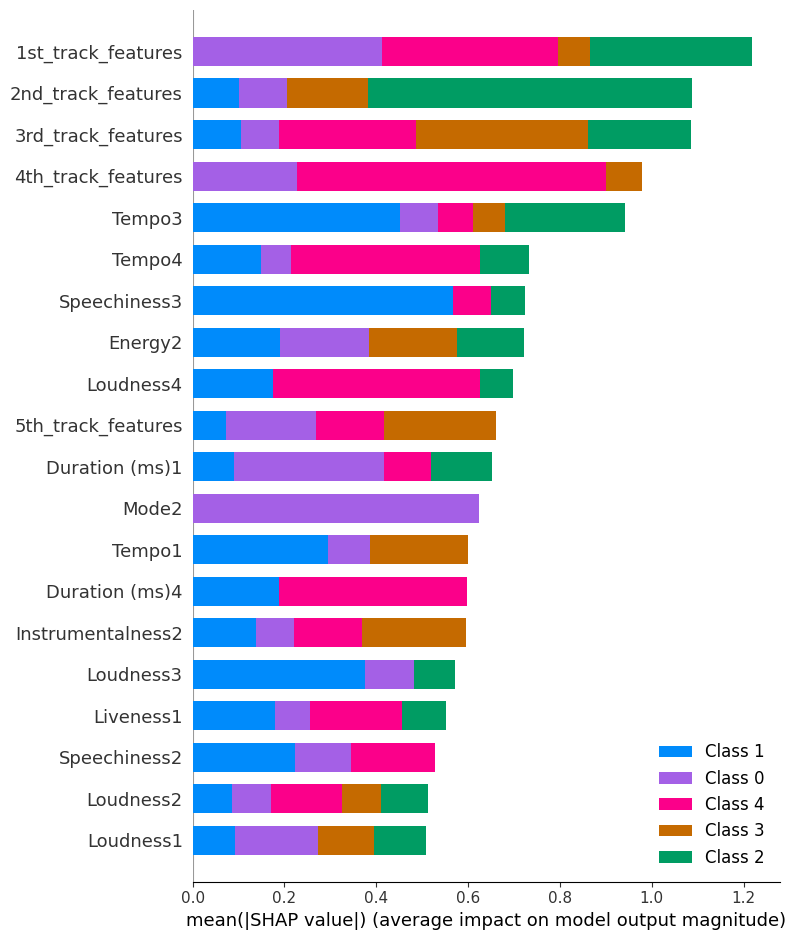

In [49]:
explainer = shap.TreeExplainer(xgb_clT)
shap_values = explainer.shap_values(df_train3)
shap.summary_plot(shap_values, df_train3)

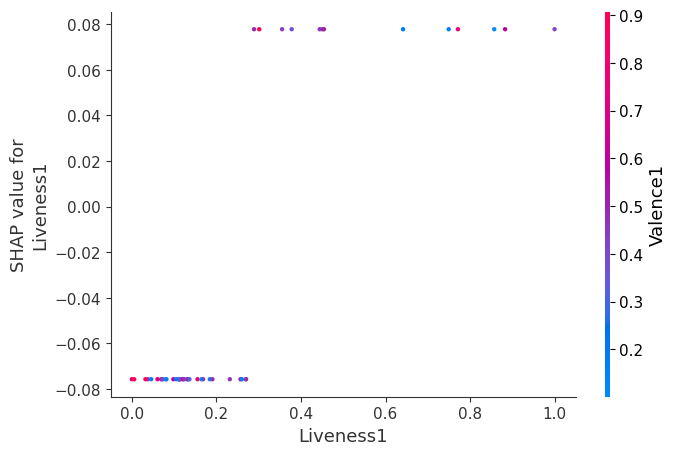

In [50]:
shap.dependence_plot('Liveness1', shap_values[0], df_train3, interaction_index="Valence1",  x_jitter=1, dot_size=10)

In [51]:
xgb_clQ = xgb.XGBClassifier(n_estimators = 1000, verbosity = 1,max_depth = 5, 
                           gamma = 0.2, subsample = 0.2, learning_rate = 0.3)
xgb_clQ.fit(df_train4, df['Q Clusters'])
xgb_clQ.score(df_train4, df['Q Clusters'])  

1.0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

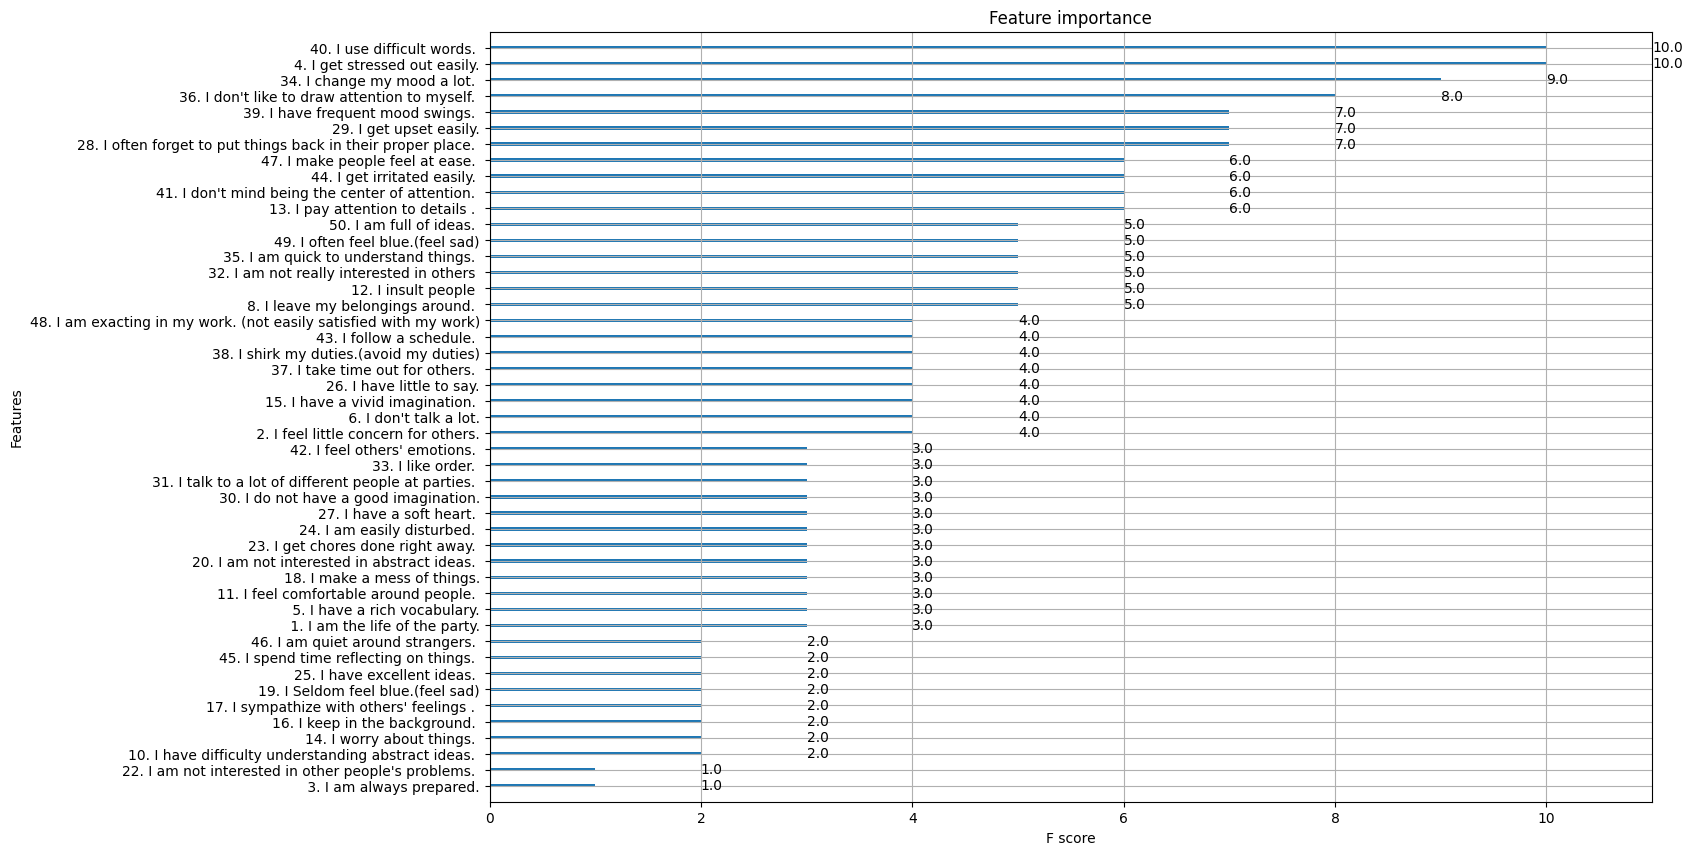

In [52]:
xgb.plot_importance(xgb_clQ)

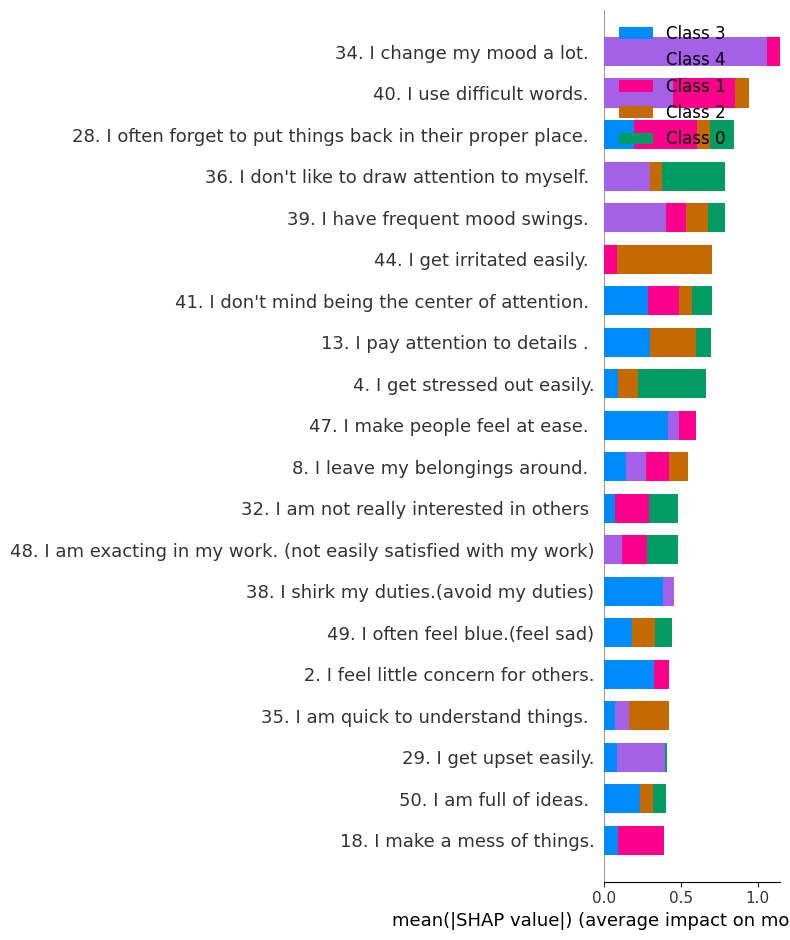

In [53]:
explainer = shap.TreeExplainer(xgb_clQ)
shap_values = explainer.shap_values(df_train4)
shap.summary_plot(shap_values, df_train4)

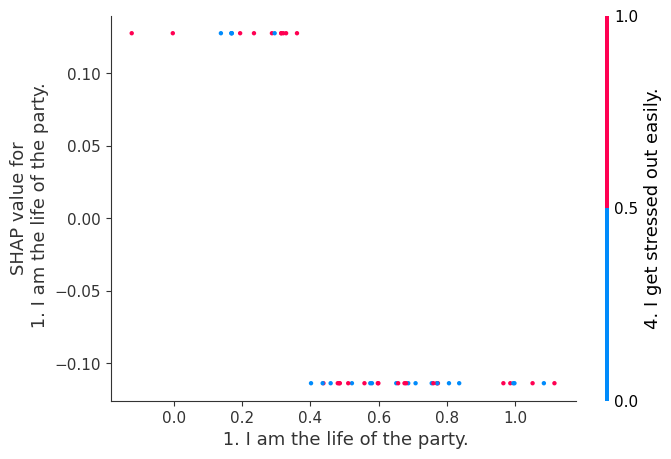

In [54]:
shap.dependence_plot(' 1. I am the life of the party.', shap_values[1], df_train4, interaction_index="4. I get stressed out easily.",  x_jitter=1, dot_size=10)